### The code aims to replicate Table 1 of Yenni et al. (2012):
#### - keeps the parameters' variations from the code
#### - filters S1 >= 1 & S2 >= 1, without it the results do not match
#### - keeps the truncated values

#### Author's original code: https://github.com/gmyenni/RareStabilizationSimulation

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

# analyN_function.r

In [2]:
def analyN(r1, r2, a11, a12, a21, a22):
    N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / (a11 - a21 * a12 / a22)
    N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / (a22 - a21 * a12 / a11)
    if np.isinf(N1) or np.isinf(N2) or np.isnan(N1) or np.isnan(N2):
        initialNsp1 = 0
        initialNsp2 = 0
        N = np.zeros((100, 2))
        N[0, :] = [initialNsp1, initialNsp2]
        for i in range(1, 100):
            N[i, 0] = max((r1 - 1 - a12 * N[i-1, 1]) / a11, 0)
            N[i, 1] = max((r2 - 1 - a21 * N[i-1, 0]) / a22, 0)
        N1 = np.mean(N[:, 0])
        N2 = np.mean(N[:, 1])
    if N1 < 0 and N2 >= 0:
        N1 = 0
        N2 = (r2 - 1) / a22
    elif N2 < 0 and N1 >= 0:
        N2 = 0
        N1 = (r1 - 1) / a11
    return N1, N2

# getNFD.r

In [3]:
def SOS(r1, r2, a11, a12, a21, a22):
    S1 = r2 / (1 + (a12 / a22) * (r2 - 1))
    S2 = r1 / (1 + (a21 / a11) * (r1 - 1))
    return S1, S2

def getPCG(r1, r2, a11, a12, a21, a22, N1, N2):
    N1_next = r1 * N1 / (1 + a11 * N1 + a12 * N2)
    N2_next = r2 * N2 / (1 + a21 * N1 + a22 * N2)
    pcg1 = np.log(N1_next) - np.log(N1)
    pcg2 = np.log(N2_next) - np.log(N2)
    return pcg1, pcg2

def getEqDensity(species, r1, r2, a11, a12, a21, a22, N_star):
    if species == 1:
        return (r2 - 1 - a21 * N_star) / a22
    elif species == 2:
        return (r1 - 1 - a12 * N_star) / a11
    else:
        raise ValueError("species must be 1 or 2")

def calculate_metrics(r1, r2, a11, a12, a21, a22, N1, N2):
    CoexistRank = 0 if N1 < 1 else 1
    S1, S2 = SOS(r1, r2, a11, a12, a21, a22) # Strength of Stabilization
    E1, E2 = r1 / r2, r2 / r1  # Fitness equivalence
    Asy = S1 - S2  # Asymmetry
    Rare = 0 if N1 == 0 and N2 == 0 else N1 / (N1 + N2)
    # Calculating covariance:
    x = np.array([N1, N2])
    y = np.array([S1, S2])
    cor_matrix = np.cov(x, y)
    cor = cor_matrix[0, 1]  # Extracting the covariance between N and S
    Rank = 0 if N1 == 0 and N2 == 0 else (2 if N1 / (N1 + N2) <= 0.25 else 1)
    return CoexistRank, E1, S1, E2, S2, Asy, cor, Rare, Rank

def getNFD(r1, r2, a11, a12, a21, a22, lowN, deltaN):
    # low-density and high-density growth and frequencies
    N_low_1 = lowN
    N_low_2 = getEqDensity(1, r1, r2, a11, a12, a21, a22, N_low_1)
    pgr_low_1, _    = getPCG(r1, r2, a11, a12, a21, a22, N_low_1, N_low_2)
    freq_low_1      = N_low_1 / (N_low_1 + N_low_2)
    N_low_2b = lowN
    N_low_1b = getEqDensity(2, r1, r2, a11, a12, a21, a22, N_low_2b)
    _, pgr_low_2   = getPCG(r1, r2, a11, a12, a21, a22, N_low_1b, N_low_2b)
    freq_low_2     = N_low_2b / (N_low_1b + N_low_2b)
    N_high_1 = lowN + deltaN
    N_high_2 = getEqDensity(1, r1, r2, a11, a12, a21, a22, N_high_1)
    pgr_high_1, _   = getPCG(r1, r2, a11, a12, a21, a22, N_high_1, N_high_2)
    freq_high_1     = N_high_1 / (N_high_1 + N_high_2)
    N_high_2b = lowN + deltaN
    N_high_1b = getEqDensity(2, r1, r2, a11, a12, a21, a22, N_high_2b)
    _, pgr_high_2  = getPCG(r1, r2, a11, a12, a21, a22, N_high_1b, N_high_2b)
    freq_high_2    = N_high_2b / (N_high_1b + N_high_2b)
    return {
        'pgr1': [pgr_low_1, pgr_high_1],
        'freq1': [freq_low_1, freq_high_1],
        'pgr2': [pgr_low_2, pgr_high_2],
        'freq2': [freq_low_2, freq_high_2]
    }

def plot_frequency_PGR(freq1, pgr1, freq2, pgr2, r1, r2, a11, a12, a21, a22, cor, figure_id):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.axhline(0, color='black', linestyle=':', linewidth=0.8)
    ax.plot(freq1, pgr1, label='N1', linestyle='-')
    ax.plot(freq2, pgr2, label='N2', linestyle='--')
    ax.set_xlabel('Frequency', fontsize=16)
    ax.set_ylabel('log(PGR)', fontsize=16)
    ax.set_xlim(-0.005, 1.01)
    ax.set_ylim(-1.01, 1.01)
    ax.set_title(f"r1={r1:.2g}, r2={r2:.2g}, a11={a11:.2g}, a12={a12:.2g}, a21={a21:.2g}, a22={a22:.2g}, \u03BD={cor:.2g}", fontsize=14, wrap=True)
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def example_parameters():
    param_sets = [
        (15, 15, 2.5, 0.1, 0.5, 0.7),
        (15, 15, 2.5, 0.1, 0.5, 0.5),
        (15, 15, 2.5, 0.1, 0.3, 0.3)
    ]
    lowN, highN = 0.001, 100
    for idx, (r1, r2, a11, a12, a21, a22) in enumerate(param_sets, start=1):
        # compute equilibrium densities
        N1, N2 = analyN(r1, r2, a11, a12, a21, a22)
        # extract correlation nu from metrics
        _, _, _, _, _, _, cor, _, _ = calculate_metrics(r1, r2, a11, a12, a21, a22, N1, N2)
        # compute low- and high-density PGR and frequencies
        nfd = getNFD(r1, r2, a11, a12, a21, a22, lowN, highN)
        plot_frequency_PGR(nfd['freq1'], nfd['pgr1'], nfd['freq2'], nfd['pgr2'], r1, r2, a11, a12, a21, a22, cor=cor, figure_id=idx)

# annualplant_2spp_det_par.r

In [4]:
def preprocess_data():
    # Defines frequency-dependent parameters
    r1_v = np.arange(15, 21)
    r2_v = np.arange(15, 21)
    a11_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.5, 2, 2.5, 3])
    a12_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    a21_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    a22_v = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1])
    # Generate all combinations of parameters using NumPy's meshgrid
    mesh = np.array(np.meshgrid(r1_v, r2_v, a11_v, a12_v, a21_v, a22_v)).T.reshape(-1, 6)
    return mesh

def Sim(k, mesh_row):
    r1, r2, a11, a12, a21, a22 = mesh_row
    N1, N2 = analyN(r1, r2, a11, a12, a21, a22)
    CoexistRank, E1, E2, S1, S2, Asy, cov, Rare, Rank = calculate_metrics(r1, r2, a11, a12, a21, a22, N1, N2)
    return np.array([r1, r2, a11, a12, a21, a22, N1, N2, E1, E2, S1, S2, Rank, CoexistRank, Asy, cov, Rare])

def postprocess_results(results, outfile):
    column_order = ['r1', 'r2', 'a11', 'a12', 'a21', 'a22', 'N1', 'N2', 'E1', 'S1', 'E2', 'S2', 'Rank', 'CoexistRank', 'Asy', 'cor', 'Rare']
    simul = pd.DataFrame(results, columns=column_order)
    simul.to_csv(outfile, index=False)

if __name__ == "__main__":
    os.makedirs('csv', exist_ok=True)
    outfile = "csv/annplant_2spp_det_rare.csv"
    mesh = preprocess_data()
    results = np.empty((len(mesh), 17), dtype=float)
    # Run the simulation for each row in the parameter combination mesh
    for k in range(len(mesh)):
        results[k] = Sim(k, mesh[k])
    postprocess_results(results, outfile)

/tmp/ipykernel_274802/1047130576.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / (a11 - a21 * a12 / a22)
/tmp/ipykernel_274802/1047130576.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / (a22 - a21 * a12 / a11)
/tmp/ipykernel_274802/1047130576.py:2: RuntimeWarning: invalid value encountered in scalar divide
  N1 = (r1 - 1 - (a12 / a22) * (r2 - 1)) / (a11 - a21 * a12 / a22)
/tmp/ipykernel_274802/1047130576.py:3: RuntimeWarning: invalid value encountered in scalar divide
  N2 = (r2 - 1 - (a21 / a11) * (r1 - 1)) / (a22 - a21 * a12 / a11)


# cor_figure.r

In [5]:
def cor_figure():
    dat_det = pd.read_csv("csv/annplant_2spp_det_rare.csv")
    dat_det = dat_det.query('Rank == 2 & S1 >= 1 & S2 >= 1').copy() # Apply filter
    dat_det.reset_index(drop=True, inplace=True)
    dat_det = np.trunc(dat_det * 100) / 100.0  # Truncate to two decimals
    dat_det.sort_values(by=['a22', 'a21', 'a12', 'a11', 'r2', 'r1'], inplace=True)
    dat_det.to_csv("csv/annplant_2spp_det_rare_filtered.csv", index=False)

# figures_det.r

In [6]:
def analyze_coexistence_effect(file_path):
    dat = pd.read_csv(file_path)
    # Logistic regression
    X = sm.add_constant(dat[['S1', 'E1', 'cor']])
    y = dat['CoexistRank']
    model = sm.GLM(y, X, family=sm.families.Binomial())
    result = model.fit()
    print(f"{result.summary()}")
    # Calculation of proportions and table preparation
    nu_positive_coexistence = len(dat[(dat['cor'] >= 0) & (dat['CoexistRank'] == 1)])
    nu_positive_exclusion = len(dat[(dat['cor'] >= 0) & (dat['CoexistRank'] == 0)])
    nu_negative_coexistence = len(dat[(dat['cor'] < 0) & (dat['CoexistRank'] == 1)])
    nu_negative_exclusion = len(dat[(dat['cor'] < 0) & (dat['CoexistRank'] == 0)])
    table_data = {
        '\u03BD \u2265 0': [nu_positive_coexistence, nu_positive_exclusion],
        '\u03BD < 0': [nu_negative_coexistence, nu_negative_exclusion]
    }
    table_df = pd.DataFrame(table_data, index=['coexistence', 'exclusion'])
    print("\nCoexistence and Exclusion based on \u03BD:\n", table_df)
    negative_nu = dat[dat['cor'] < 0]
    non_negative_nu = dat[dat['cor'] >= 0]
    negative_nu_coexist = negative_nu[negative_nu['CoexistRank'] == 1]
    non_negative_nu_coexist = non_negative_nu[non_negative_nu['CoexistRank'] == 1]
    proportion_negative_nu = len(negative_nu_coexist) / len(negative_nu) if len(negative_nu) > 0 else 0
    proportion_non_negative_nu = len(non_negative_nu_coexist) / len(non_negative_nu) if len(non_negative_nu) > 0 else 0
    # Confidence intervals for proportions
    neg_nu_confint = proportion_confint(count=len(negative_nu_coexist), nobs=len(negative_nu), alpha=0.05, method='wilson')
    non_neg_nu_confint = proportion_confint(count=len(non_negative_nu_coexist), nobs=len(non_negative_nu), alpha=0.05, method='wilson')
    print("\nAnalysis on Negative \u03BD:")
    print(f"Proportion of coexistence with \u03BD < 0: {proportion_negative_nu:.2g} (95% CI: {neg_nu_confint})")
    print(f"Proportion of coexistence with \u03BD \u2265 0: {proportion_non_negative_nu:.2g} (95% CI: {non_neg_nu_confint})")
    # Decision based on overlap
    if neg_nu_confint[1] < non_neg_nu_confint[0]:
        print(f"The confidence intervals overlap, indicating they are statistically the same, not supporting the authors' results.")
    elif neg_nu_confint[0] > non_neg_nu_confint[1]:
        print(f"Higher coexistence observed with \u03BD < 0, supporting the authors' results.")
    else:
        print(f"Higher coexistence observed with \u03BD \u2265 0, not supporting the authors' results.")
    return result

Original Results by Yenni et al. (2012)
                 Generalized Linear Model Regression Results                  
Dep. Variable:            CoexistRank   No. Observations:                18056
Model:                            GLM   Df Residuals:                    18052
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3507.3
Date:                Fri, 13 Jun 2025   Deviance:                       7014.6
Time:                        10:50:12   Pearson chi2:                 2.76e+04
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6117
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       

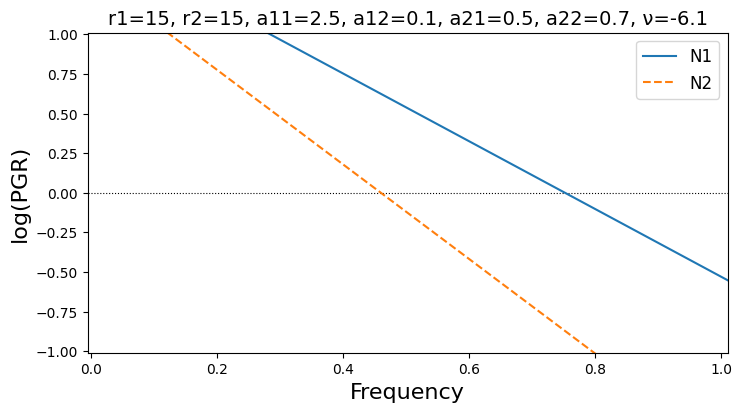

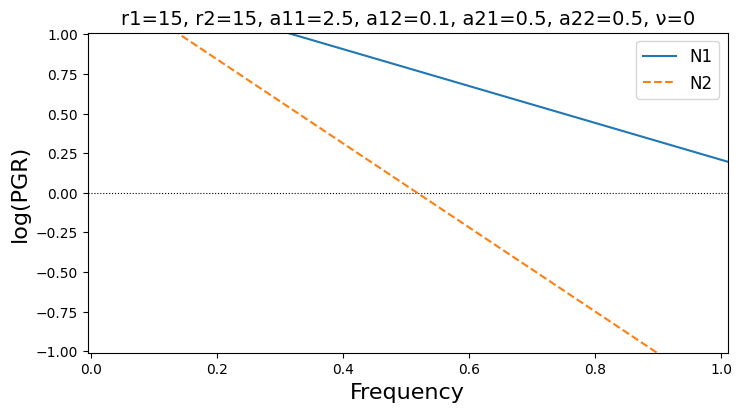

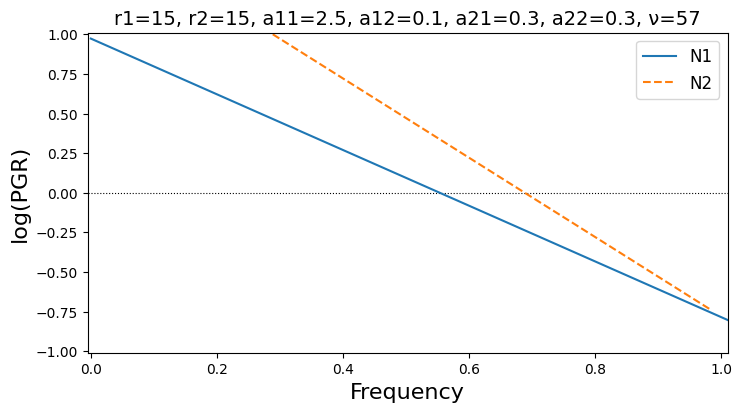

In [7]:
def main():
    warnings.filterwarnings("ignore")
    output_file = "csv/annplant_2spp_det_rare_filtered.csv"
    data_grid = preprocess_data()
    simulations = np.array([Sim(k, row) for k, row in enumerate(data_grid)])
    postprocess_results(simulations, output_file)
    cor_figure()  # apply filters
    yenni_file = "csv/annplant_2spp_det_rare.txt"
    if os.path.exists(yenni_file):
        print("Original Results by Yenni et al. (2012)")
        analyze_coexistence_effect(yenni_file)
    else:
        print(f"File not found: {os.path.abspath(yenni_file)}. To include original Yenni et al. (2012) results, please copy 'annplant_2spp_det_rare.txt' into this directory. Skipping.")
    print("\nReproduction of the Authors' Results")
    print("\nFigures Examples:")
    analyze_coexistence_effect(output_file)
    example_parameters()

if __name__ == "__main__":
    main()